# Приоритизация гипотез и анализ результатов А/В тестирования

## Цель исследования
Провести приоритизацию гипотез и выполнить анализ результатов А/В тестирования для веб-сайта.

## Задачи исследования
• Приоритизировать гипотезы из списка гипотез, предоставленного отделом маркетинга    
• Подготовить данные и провести исследовательский анализ  
• Проверить результаты А/В тестирования 

## Подготовка к работе

In [1]:
!pip install pandas
import pandas as pd
import numpy as np

!pip install matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt

!pip install seaborn
import seaborn as sns

!pip install scipy
import scipy.stats as stats

import warnings
warnings.filterwarnings(action='ignore')

import os
os.chdir('/home/jovyan/N2024/projects/ab_testing')

  Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl.metadata (91 kB)
  Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (62 kB)
  Using cached tzdata-2025.2-py2.py3-none-any.whl.metadata (1.4 kB)
Using cached pandas-2.3.3-cp312-cp312-manylinux_2_24_x86_64.manylinux_2_28_x86_64.whl (12.4 MB)
Using cached numpy-2.3.4-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl (16.6 MB)
Using cached tzdata-2025.2-py2.py3-none-any.whl (347 kB)
  Using cached matplotlib-3.10.7-cp312-cp312-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (11 kB)
  Using cached contourpy-1.3.3-cp312-cp312-manylinux_2_27_x86_64.manylinux_2_28_x86_64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.60.1-cp312-cp312-manylinux1_x86_64.manylinux2014_x86_64.manylinux_2_17_x86_64.manylinux_2_5_x86_64.whl.metadata (112 kB)
  Using cached kiwisolver-1.4.9-cp312-cp312-m

## Приоритизация гипотез

Посмотрим на список гипотез, предоставленный отделом маркетинга:

In [34]:
path = 'hypotheses.csv'
hypotheses = pd.read_csv(path, sep=',', encoding='utf-8-sig')

hypotheses

,hypothesis,reach,impact,confidence,efforts
0,Добавить блок товаров «Вам также могут понрави...,9,7,8,8
1,Упростить форму оформления заказа путем сокращ...,8,9,6,4
2,Изменить цвет фона сайта с белого на черный дл...,9,5,5,1
3,Добавить индикатор «Осталось N штук» для созда...,8,7,4,2
4,Ввести мини-чат поддержки на страницах корзины...,6,8,6,7


В таблице **hypotheses** имеются столбцы:  
• hypothesis - краткое описание гипотезы  
• reach - охват пользователей по 10-балльной шкале  
• impact - влияние на пользователей по 10-балльной шкале  
• confidence - уверенность в гипотезе по 10-балльной шкале  
• efforts - затраты ресурсов на проверку гипотезы по 10-балльной шкале

Применим одни из самых популярных методов приоритезации гипотез - ICE и RICE. Разница между ними заключается в том, что одна учитывает количество пользователей, которых затронут изменения, а другая - нет.

In [35]:
hypotheses['ice'] = hypotheses['impact'] * hypotheses['confidence'] / hypotheses['efforts']

hypotheses[['hypothesis', 'ice']].sort_values(by='ice', ascending=False)

,hypothesis,ice
2,Изменить цвет фона сайта с белого на черный дл...,25.000000
3,Добавить индикатор «Осталось N штук» для созда...,14.000000
1,Упростить форму оформления заказа путем сокращ...,13.500000
0,Добавить блок товаров «Вам также могут понрави...,7.000000
4,Ввести мини-чат поддержки на страницах корзины...,6.857143


In [36]:
hypotheses['rice'] = hypotheses['reach'] * hypotheses['impact'] * hypotheses['confidence'] / hypotheses['efforts']

hypotheses[['hypothesis', 'rice']].sort_values(by='rice', ascending=False)

,hypothesis,rice
2,Изменить цвет фона сайта с белого на черный дл...,225.000000
3,Добавить индикатор «Осталось N штук» для созда...,112.000000
1,Упростить форму оформления заказа путем сокращ...,108.000000
0,Добавить блок товаров «Вам также могут понрави...,63.000000
4,Ввести мини-чат поддержки на страницах корзины...,41.142857


Оба метода приоритезации показали, что наиболее приоритетной гипотезой является **"Изменить цвет фона сайта с белого на черный для увеличения вовлеченности клиентов"**, следовательно, берем в работу ее первой, и проводим А/В-тестирование.

## Ключевая метрика

Основным показателем эффективности эксперимента является **конверсия в оформление заказа (доля пользователей, совершивших целевое действие)**.  
В качестве вспомогательных метрик рассматриваются глубина просмотра (количество просмотренных страниц за сессию) и средняя длительность сеанса (время, проведённое пользователем на сайте за одну сессию).

**Основная гипотеза:**  
Н0: Изменение цвета фона сайта с белого на черный не оказывает статистически значимого влияния на среднюю конверсию в оформление заказа.(m1-m2=0)  
Н1: Изменение цвета фона сайта с белого на черный оказывает статистически значимое влияние на среднюю конверсию в оформление заказа. (m1-m2!=0)  
  
Тест – двусторонний, уровень статистической значимости (α) = 0,05.

## Обзор и предобработка данных

Ссылка на датасет на Kaggle: https://www.kaggle.com/datasets/adarsh0806/ab-testing-practice?resource=download

In [37]:
path = 'ab_testing_results.csv'
df = pd.read_csv(path, sep=',', encoding='utf-8-sig')

df.head(5)

,User ID,Group,Page Views,Time Spent,Conversion,Device,Location
0,14292,B,3,424,No,Mobile,Northern Ireland
1,11682,A,9,342,No,Mobile,Scotland
2,19825,A,2,396,No,Desktop,Northern Ireland
3,16080,B,4,318,No,Desktop,Wales
4,18851,A,1,338,Yes,Desktop,Scotland


В таблице **ab_testing_results** имеются столбцы:  
• User ID - идентификатор пользователя  
• Group - контрольная (A) или тестовая (B)  
• Page Views - количество просмотренных страниц  
• Time Spent - время, проведенное пользователем на сайте (в секундах) за одну сессию  
• Conversion - совершено целевое действие (Yes/No)  
• Device - тип используемого устройства (Desktop/Mobile)  
• Location - страна нахождения пользователя  

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   User ID     5000 non-null   int64 
 1   Group       5000 non-null   object
 2   Page Views  5000 non-null   int64 
 3   Time Spent  5000 non-null   int64 
 4   Conversion  5000 non-null   object
 5   Device      5000 non-null   object
 6   Location    5000 non-null   object
dtypes: int64(3), object(4)
memory usage: 273.6+ KB


In [39]:
# Приведение названий колонок к стилю python:

df = df.rename(columns={'User ID':'user_id',
                        'Group':'group',
                        'Page Views':'page_views',
                        'Time Spent':'time_spent',
                        'Conversion': 'conversion',
                        'Device': 'device',
                        'Location': 'location'})

In [40]:
# Проверка количественных данных на необходимость очистки:

for var in ['page_views', 'time_spent']:
    print(var)
    print('Среднее:', df[var].mean())
    print('Минимум:', df[var].min())
    print('Максимум:', df[var].max())

page_views
Среднее: 7.5376
Минимум: 1
Максимум: 14
time_spent
Среднее: 242.5126
Минимум: 40
Максимум: 449


In [41]:
# Проверка остальных данных на необходимость очистки:

for var in ['group', 'conversion', 'device', 'location']:
    print(df.groupby(var).size())
    print()

group
A    2519
B    2481
dtype: int64

conversion
No     4515
Yes     485
dtype: int64

device
Desktop    2538
Mobile     2462
dtype: int64

location
England             1246
Northern Ireland    1242
Scotland            1281
Wales               1231
dtype: int64



Данные в очистке не нуждаются.

In [42]:
# Замена значений No/Yes в столбце conversion на 0/1.

df['conversion'] = df['conversion'].mask(df['conversion'] == 'Yes', 1)
df['conversion'] = df['conversion'].mask(df['conversion'] == 'No', 0)

df.groupby('conversion').size()

conversion
0    4515
1     485
dtype: int64

In [43]:
# Посмотрим на число уникальных пользователей в каждой из групп:

print ('Количество пользователей в группе А:', df[df['group']=='A']['user_id'].nunique())
print ('Количество пользователей в группе B:', df[df['group']=='B']['user_id'].nunique())
print ('Общее число пользователей:', df['user_id'].nunique())

Количество пользователей в группе А: 2519
Количество пользователей в группе B: 2481
Общее число пользователей: 5000


####
## Исследовательский анализ

Сначала визуализируем распределение количества просмотренных страниц и времени, проведенного на сайте, чтобы посмотреть в целом на вовлечённость пользователей.

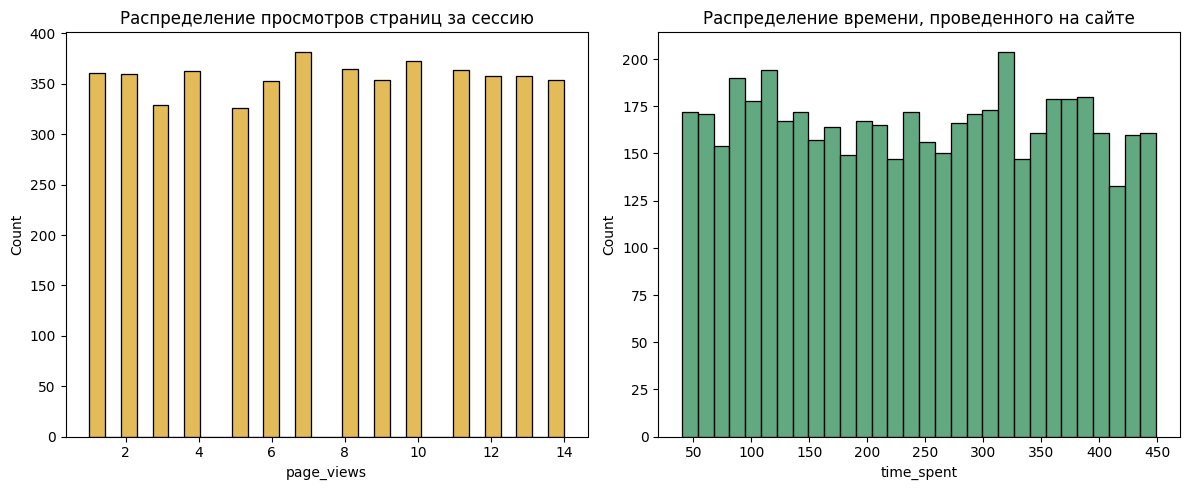

In [44]:
# Построение гистограммы просмотров страниц и затраченного времени

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(df['page_views'], bins=30, ax=ax[0], color='goldenrod')
ax[0].set_title('Распределение просмотров страниц за сессию')
sns.histplot(df['time_spent'], bins=30, ax=ax[1], color='seagreen')
ax[1].set_title('Распределение времени, проведенного на сайте')
plt.tight_layout()
plt.show()

Посмотрим на разницу в среднем арифметическом по метрикам между группами А и В.

In [45]:
# Средние значения метрик по группам

df.groupby('group')[['page_views', 'time_spent', 'conversion']].mean()

,page_views,time_spent,conversion
group,,,
A,7.581580,241.733227,0.05399
B,7.492946,243.303910,0.140669


Посетители из экспериментальной группы чаще совершают целевое действие, чем посетители из контрольной группы. Остальные метрики сильно не отличаются по группам.

Проанализируем влияние устройства и местоположения на вовлеченность посетителей.

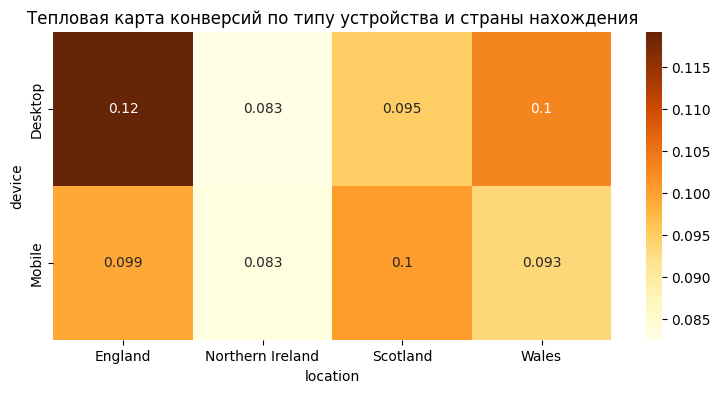

In [46]:
# Тепловая карта конверсий по устройству и локацияи

grouped = pd.pivot_table(
    df,
    index='device',
    columns='location',
    values='conversion',
    aggfunc='mean'
).astype(float)

plt.figure(figsize=(9, 4))
sns.heatmap(grouped, annot=True, cmap="YlOrBr")
plt.title("Тепловая карта конверсий по типу устройства и страны нахождения")
plt.show()

Самая высока конверсия у посетителей из Англии, посещающие сайт с desktop. Самая низкая - у посетителей из Северной Ирландии.

In [47]:
# Конверсия по типу устройства

df.groupby('device').conversion.mean()

device
Desktop    0.099685
Mobile     0.094232
Name: conversion, dtype: object

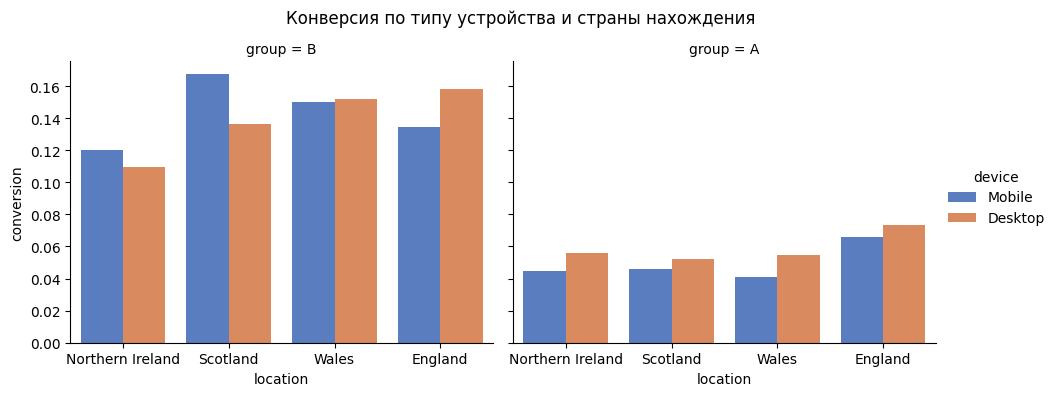

In [48]:
# Столбчатая диаграмма конверсии по странам и типу устройства (по группам)

graph = sns.catplot(data=df,
                    x="location",
                    y="conversion",
                    hue="device",
                    kind="bar",
                    col="group",
                    height=4,
                    aspect=1.2,
                    ci=None,
                    palette="muted")
graph.fig.suptitle("Конверсия по типу устройства и страны нахождения")
graph.fig.subplots_adjust(top=0.85)
plt.show()

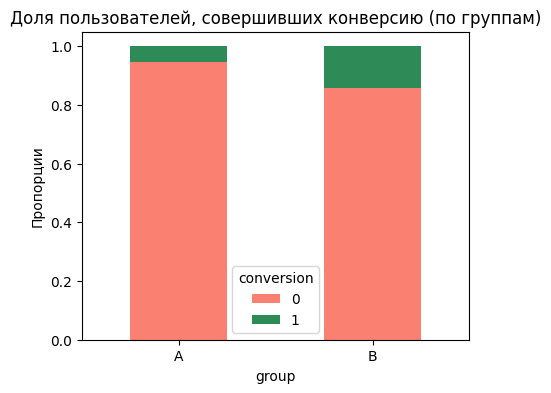

In [49]:
# Столбчатая диаграмма с накоплением

conversion_rate = df.groupby('group')['conversion'].value_counts(normalize=True).unstack()
conversion_rate.plot(kind='bar', stacked=True, color=['salmon', 'seagreen'], figsize=(5, 4))
plt.title('Доля пользователей, совершивших конверсию (по группам)')
plt.ylabel('Пропорции')
plt.xticks(rotation=0)
plt.show()

## Проверка гипотез

#### 1. Статистическая значимость различий в конверсии в целевое действие между группами

**Нулевая гипотеза (Н0):** Изменение цвета фона сайта с белого на черный не оказывает статистически значимого влияния на среднюю конверсию в оформление заказа.(m1-m2=0)  
**Альтернативная гипотеза (Н1):** Изменение цвета фона сайта с белого на черный оказывает статистически значимое влияние на среднюю конверсию в оформление заказа. (m1-m2!=0)  

Тест – двусторонний, уровень статистической значимости (α) = 0,05.

Проверим гипотезу с помощью **Chi-Square Test**.

In [50]:
# Таблица сопряжённости
table = pd.crosstab(df['group'], df['conversion'])

# Хи-квадрат тест
chi2, p, dof, expected = stats.chi2_contingency(table)

print(f"χ²={chi2:.3f}, p-value={p:.5f}")
print("Различия значимы" if p < 0.05 else "Различия незначимы")

χ²=106.228, p-value=0.00000
Различия значимы


Так как p-value < 0.05, отвергаем нулевую гипотезу об отсутствии статистических различий в конверсии между группами, и принимаем альтернативную гипотезу о **наличии статистически значимой разницы в средней конверсии между группами А и В.**

In [51]:
# Выведем средние по конверсиям по группам

print(f"По группе А: {df.loc[df['group'] == 'A', 'conversion'].mean():.3f}, По группе B: {df.loc[df['group'] == 'B', 'conversion'].mean():.3f}")

По группе А: 0.054, По группе B: 0.141


#### 2. Статистическая значимость различий в среднем времени сессии между группами

**Нулевая гипотеза (Н0):** Различий в среднем времени, проведённом пользователем на сайте за одну сессию, между группами нет. (m1-m2=0)  
**Альтернативная гипотеза (Н1):** Различия в среднем времени, проведённом пользователем на сайте за одну сессию, между группами есть. (m1-m2!=0)

Тест – двусторонний, уровень статистической значимости (α) = 0,05.

In [52]:
# Создадим переменные времени сессии по группам

group_a_tm = df[df['group'] == 'A']['time_spent']
group_b_tm = df[df['group'] == 'B']['time_spent']

<Axes: xlabel='group', ylabel='time_spent'>

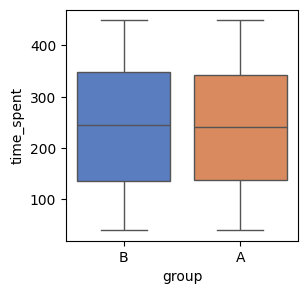

In [53]:
# Проверка на экстремальные выбросы

plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x='group', y='time_spent', palette='muted')

Выбросы не выявлены.

Используем тест Шапиро–Уилка, чтобы определить, распределены ли данные нормально.  
H0: распределение нормальное  
H1: распределение отлично от нормального

In [54]:
# Проверка на нормальность распределения

for i in (group_a_tm, group_b_tm):
    stat, p = stats.shapiro(i)
    print(f"Statistic = {stat:.3f}, p-value = {p:.3f}")

Statistic = 0.955, p-value = 0.000
Statistic = 0.951, p-value = 0.000


У обеих подвыборок p-value < 0.05, следовательно их распределение отлично от нормального. Значит, для проверки равенства средних значений будем использовать **непараметрические критерии** (применение параметрических нежелательно).

Применим **тест Манна–Уитни** (U-test).

In [55]:
# Тест манна-Уитни

stat, p = stats.mannwhitneyu(group_a_tm, group_b_tm, alternative='two-sided')
print(f"Statistic = {stat:.3f}, p-value = {p:.5f}")

Statistic = 3101095.000, p-value = 0.64203


Так как p-value > 0.05, нет оснований отвергнуть H0 о том, что **средние значения времени, проведённого посетителями из обеих групп (А и В) на сайте за одну сессию равны.** Хотя среднее арифметическое данной метрики по группе В немного больше, это может быть случайностью.

#### 3. Статистическая значимость различий в глубине просмотра между группами
**Нулевая гипотеза (Н0):** Различий в среднем количестве просмотренных страниц за сессию между группами нет. (m1-m2=0)  
**Альтернативная гипотеза (Н1):** Различия в среднем количестве просмотренных страниц за сессию между группами есть. (m1-m2!=0)

Тест – двусторонний, уровень статистической значимости (α) = 0,05.

In [56]:
# Создадим переменные глубины просмотра по группам

group_a_pv = df[df['group'] == 'A']['page_views']
group_b_pv = df[df['group'] == 'B']['page_views']

<Axes: xlabel='group', ylabel='page_views'>

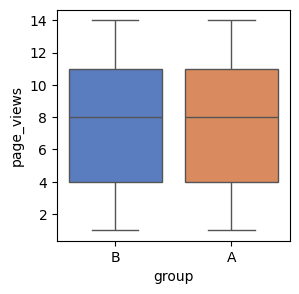

In [57]:
# Проверка на экстремальные выбросы

plt.figure(figsize=(3, 3))
sns.boxplot(data=df, x='group', y='page_views', palette='muted')

Выбросы не выявлены.

Используем тест Шапиро–Уилка, чтобы определить, распределены ли данные нормально.  
H0: распределение нормальное  
H1: распределение отлично от нормального  

In [58]:
# Проверка на нормальность распределения

for i in (group_a_pv, group_b_pv):
    stat, p = stats.shapiro(i)
    print(f"Statistic = {stat:.3f}, p-value = {p:.3f}")

Statistic = 0.942, p-value = 0.000
Statistic = 0.948, p-value = 0.000


У обеих подвыборок p-value < 0.05, следовательно распределение выборок отлично от нормального. Значит, для проверки равенства средних значений будем использовать **непараметрические критерии** (применение параметрических нежелательно).

Применим **тест Манна–Уитни** (U-test).

In [59]:
# Тест манна-Уитни

stat, p = stats.mannwhitneyu(group_a_pv, group_b_pv, alternative='two-sided')
print(f"Statistic = {stat:.3f}, p-value = {p:.5f}")

Statistic = 3165458.000, p-value = 0.42468


Так как p-value > 0.05, нет оснований отвергнуть H0 о том, что **средние количества просмотренных страниц за сессию по группам А и В равны.**

## Результаты A/B-теста и выводы

• Тест Chi-Square показал, что различие в конверсии между группами А и В статистически значимо;  
• Тест Манна-Уитни показал, что статистически значимых различий по средним длительности сессии и глубине просмотра между группами нет;  
• Внедрение чёрного фона сайта для всех пользователей **рекомендуется**, так как эксперимент показал положительный результат по одной из трех метрик (конверсия), при этом незначительно повлиял на другие две.

Исходя из указанных результатов и основной тестируемой гипотезы (направленной на увеличение конверсии) следует остановить тест, **признать его успешным**, зафиксировать наличие различий между группами по конверсии в целевое действие (в пользу группы В).